# MSER

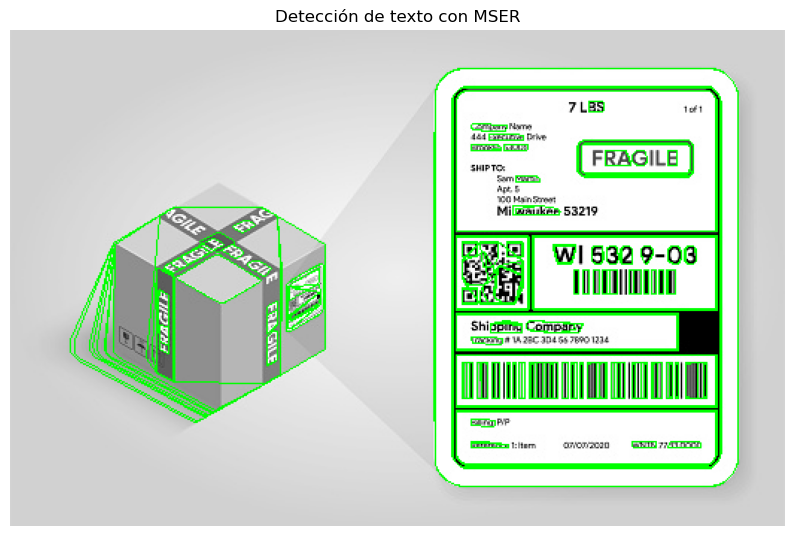

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


imagen = cv2.imread('assets/label1.jpg', cv2.IMREAD_GRAYSCALE)


mser = cv2.MSER_create()


regiones, _ = mser.detectRegions(imagen)


imagen_color = cv2.cvtColor(imagen, cv2.COLOR_GRAY2BGR)


for region in regiones:
    contorno = cv2.convexHull(region.reshape(-1, 1, 2))
    cv2.polylines(imagen_color, [contorno], True, (0, 255, 0), 1)


imagen_rgb = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(imagen_rgb)
plt.title('Detección de texto con MSER')
plt.axis('off')
plt.show()


# MSER + OCR test


In [ ]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

# Mostrar imágenes dentro del notebook
%matplotlib inline

# Ruta de la imagen
ruta_imagen = 'assets/text.jpg'  # Cambia esto a la ruta correcta si es necesario

# Cargar imagen
imagen = cv2.imread(ruta_imagen)

# Verificar si la imagen se cargó correctamente
if imagen is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen: {ruta_imagen}")

# Convertir a escala de grises
gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Crear el detector MSER
mser = cv2.MSER_create()

# Detectar regiones MSER
regiones, _ = mser.detectRegions(gris)

# Lista para almacenar resultados de texto
cajas_texto = []

# Dibujar regiones y aplicar OCR
for region in regiones:
    x, y, w, h = cv2.boundingRect(region.reshape(-1, 1, 2))
    if w > 10 and h > 10 and w/h < 5:
        roi = gris[y:y+h, x:x+w]
        texto = pytesseract.image_to_string(roi, config='--psm 7')
        texto = texto.strip()
        if texto:
            cajas_texto.append((x, y, w, h, texto))
            cv2.rectangle(imagen, (x, y), (x+w, y+h), (0, 255, 0), 1)

# Convertir BGR a RGB para mostrar con matplotlib
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

# Mostrar la imagen con matplotlib
plt.figure(figsize=(12, 10))
plt.imshow(imagen_rgb)
plt.title('Texto detectado con MSER + Tesseract')
plt.axis('off')
plt.show()

# Imprimir los textos detectados
for x, y, w, h, texto in cajas_texto:
    print(f"Texto en ({x},{y},{w},{h}): {texto}")


# Watershed

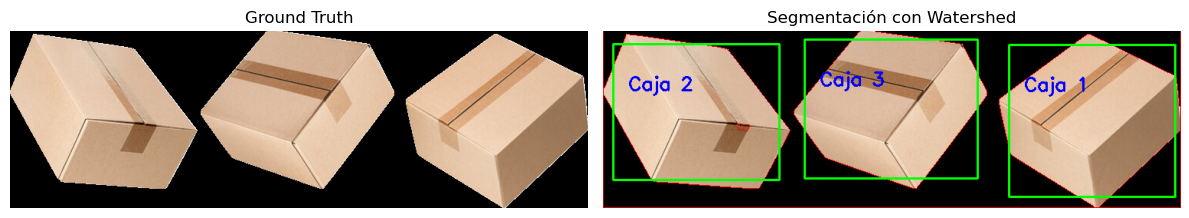

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imagen = cv2.imread('assets/boxes.png')
gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)


_, binaria = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


kernel = np.ones((3, 3), np.uint8)
abierta = cv2.morphologyEx(binaria, cv2.MORPH_OPEN, kernel, iterations=2)


fondo_seguro = cv2.dilate(abierta, kernel, iterations=3)

dist_transform = cv2.distanceTransform(abierta, cv2.DIST_L2, 5)
_, primer_plano = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)
primer_plano = np.uint8(primer_plano)

desconocido = cv2.subtract(fondo_seguro, primer_plano)

_, marcadores = cv2.connectedComponents(primer_plano)

marcadores = marcadores + 1
marcadores[desconocido == 255] = 0

imagen_color = imagen.copy()
cv2.watershed(imagen_color, marcadores)


imagen_color[marcadores == -1] = [0, 0, 255]


contornos, _ = cv2.findContours(primer_plano, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contornos):
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(imagen_color, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(imagen_color, f"Caja {i+1}", (x+20, y+60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# Mostrar resultados
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB))
plt.title("Segmentación con Watershed")
plt.axis("off")

plt.tight_layout()
plt.show()
